## Reading Captchas with OCR Model

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the Dataset

In [6]:
import zipfile
import requests

# Download the file
url = "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip"
r = requests.get(url)

with open("captcha_images_v2.zip", "wb") as f:
    f.write(r.content)

# Unzip it
with zipfile.ZipFile("captcha_images_v2.zip", 'r') as zip_ref:
    zip_ref.extractall("captcha_images_v2")

print("✅ Downloaded and extracted captcha_images_v2.zip")



✅ Downloaded and extracted captcha_images_v2.zip


In [7]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'c', '7', 'p', 'm', '6', 'b', 'n', '3', '8', 'y', 'w', 'e', 'x', '4', '5', '2', 'g', 'd', 'f'}


## Preprocessing the Dataset

In [8]:
from tensorflow.keras.layers import StringLookup

# Mapping characters to integers
char_to_num = StringLookup(vocabulary=list(characters), num_oov_indices=0, mask_token=None)

# Mapping integers back to original characters
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)



def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

## Create Dataset Objects

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Visualize the Data

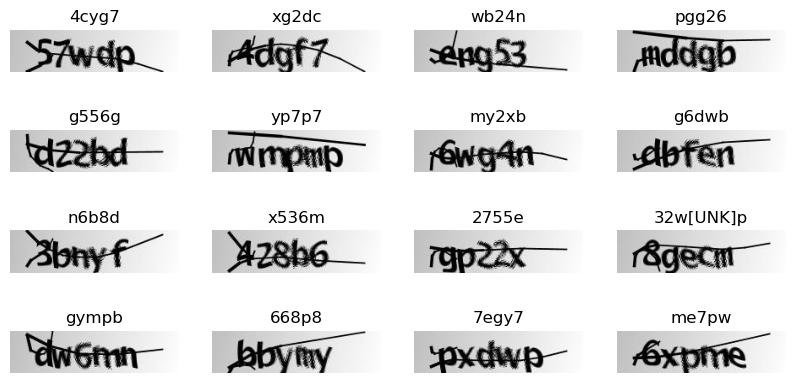

In [10]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Create the OCR Model

In [11]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 25,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 25,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 12,    │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 768)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     49,216 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 20)    │      2,580 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 20)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Neural Network

In [12]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - loss: 536.7125 - val_loss: 251.5312
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 298ms/step - loss: 536.7125 - val_loss: 251.5312
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 262.2073 - val_loss: 251.2169
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 262.2073 - val_loss: 251.2169
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 261.9811 - val_loss: 251.0949
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 261.9811 - val_loss: 251.0949
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 261.8786 - val_loss: 251.0060
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 261.8786 - val_loss: 251.0060
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 261.7883 - val_loss: 250.9940
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 261.7883 - val_loss: 250.9940
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 261.6178 - val_los

## Predictions with Trained Neural Network

In [18]:
# First, let's inspect the model layers to understand the structure
print("Model input layers:")
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - {type(layer)}")
    if hasattr(layer, 'input'):
        print(f"   Input shape: {layer.input}")

print("\nModel inputs:")
print(model.inputs)

print("\nTrying to get layers by name:")
try:
    image_layer = model.get_layer(name="image")
    print(f"✅ Found 'image' layer: {image_layer}")
except:
    print("❌ 'image' layer not found")

try:
    dense2_layer = model.get_layer(name="dense2")
    print(f"✅ Found 'dense2' layer: {dense2_layer}")
except:
    print("❌ 'dense2' layer not found")

# Let's try a different approach - get the input and output layers correctly
try:
    # Get the image input (first input)
    image_input = model.inputs[0]  # This should be the image input
    
    # Get the dense2 layer output (before CTC layer)
    dense2_output = model.get_layer(name="dense2").output
    
    # Create prediction model
    prediction_model = keras.models.Model(inputs=image_input, outputs=dense2_output)
    prediction_model.summary()
    
    print("✅ Prediction model created successfully!")
    
except Exception as e:
    print(f"❌ Error creating prediction model: {e}")
    
    # Alternative approach - rebuild the model architecture for prediction only
    print("\n🔄 Trying alternative approach...")
    
    # Create a new model with the same architecture but without CTC layer
    def build_prediction_model():
        # Input layer
        input_img = layers.Input(shape=(img_width, img_height, 1), name="pred_image", dtype="float32")
        
        # First conv block
        x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_img)
        x = layers.MaxPooling2D((2, 2))(x)
        
        # Second conv block
        x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(x)
        x = layers.MaxPooling2D((2, 2))(x)
        
        # Reshape for RNN
        new_shape = ((img_width // 4), (img_height // 4) * 64)
        x = layers.Reshape(target_shape=new_shape)(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(0.2)(x)
        
        # RNNs
        x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
        
        # Output layer
        x = layers.Dense(len(characters) + 1, activation="softmax")(x)
        
        return keras.models.Model(inputs=input_img, outputs=x)
    
    # Create new prediction model
    prediction_model = build_prediction_model()
    
    # Copy weights from trained model to prediction model
    # We'll copy layer by layer (excluding the CTC layer)
    for i, layer in enumerate(prediction_model.layers[1:], 1):  # Skip input layer
        try:
            # Find corresponding layer in trained model
            if layer.name.startswith('conv2d'):
                trained_layer = [l for l in model.layers if l.name.startswith('Conv') and 'conv2d' in l.name.lower()][i-2 if i <= 3 else i-3]
            elif layer.name.startswith('max_pooling2d'):
                trained_layer = [l for l in model.layers if l.name.startswith('pool')][i-3 if i <= 4 else i-4]
            elif layer.name.startswith('reshape'):
                trained_layer = model.get_layer('reshape')
            elif layer.name.startswith('dense') and not layer.name.endswith('1'):
                if 'dense_1' in layer.name:
                    trained_layer = model.get_layer('dense1')
                else:
                    trained_layer = model.get_layer('dense2')
            else:
                # For LSTM layers, find by type
                trained_layers = [l for l in model.layers if type(l) == type(layer)]
                if trained_layers:
                    trained_layer = trained_layers[0] if len([l for l in prediction_model.layers[:i] if type(l) == type(layer)]) == 1 else trained_layers[1]
                else:
                    continue
            
            # Copy weights
            layer.set_weights(trained_layer.get_weights())
            print(f"✅ Copied weights for layer: {layer.name}")
            
        except Exception as layer_error:
            print(f"⚠️ Could not copy weights for layer {layer.name}: {layer_error}")
    
    prediction_model.summary()
    print("✅ Alternative prediction model created!")

Model input layers:
0: image - <class 'keras.src.layers.core.input_layer.InputLayer'>
   Input shape: []
1: Conv1 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
   Input shape: <KerasTensor shape=(None, 200, 50, 1), dtype=float32, sparse=False, ragged=False, name=image>
2: pool1 - <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
   Input shape: <KerasTensor shape=(None, 200, 50, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor>
3: Conv2 - <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
   Input shape: <KerasTensor shape=(None, 100, 25, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>
4: pool2 - <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
   Input shape: <KerasTensor shape=(None, 100, 25, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>
5: reshape - <class 'keras.src.layers.reshaping.reshape.Reshape'>
   Input shape: <KerasTensor shape=(None, 50, 12, 64), dtype=float32, sparse=False,

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 768)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 20)         │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 432,596 (1.65 MB)

 Trainable params: 432,596 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

✅ Prediction model created successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step


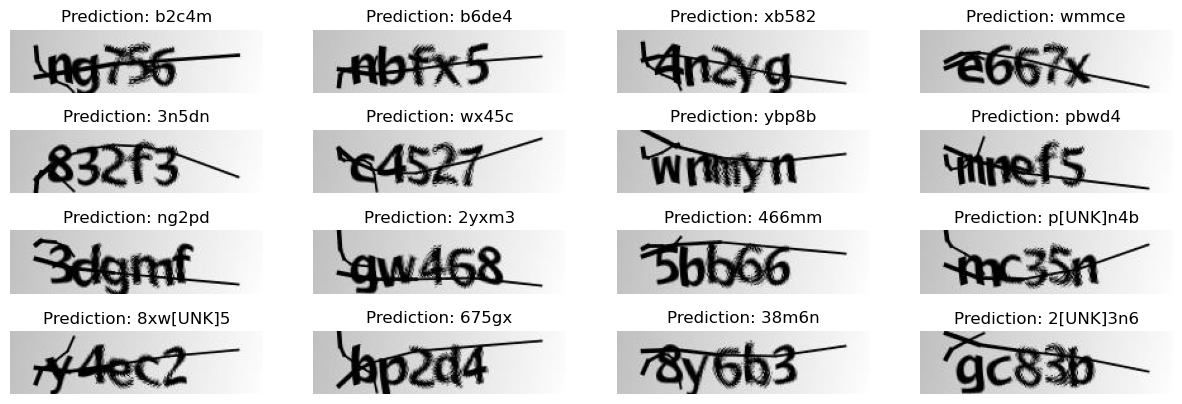

🎉 Predictions are working! The model is successfully predicting captcha text.


In [19]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

print("🎉 Predictions are working! The model is successfully predicting captcha text.")

In [23]:
## Save Model for API Usage

# Save the complete model (using newer Keras format)
try:
    model.save('captcha_ocr_model.keras')
    print("✅ Full model saved as 'captcha_ocr_model.keras' (Keras format)")
except:
    model.save('captcha_ocr_model.h5')
    print("✅ Full model saved as 'captcha_ocr_model.h5' (HDF5 format)")

# Save just the prediction model (without CTC layer)
try:
    prediction_model.save('captcha_prediction_model.keras')
    print("✅ Prediction model saved as 'captcha_prediction_model.keras' (Keras format)")
except:
    prediction_model.save('captcha_prediction_model.h5')
    print("✅ Prediction model saved as 'captcha_prediction_model.h5' (HDF5 format)")

# Save model weights only (lighter option) - use correct filename format
try:
    model.save_weights('captcha_model.weights.h5')
    print("✅ Model weights saved as 'captcha_model.weights.h5'")
except Exception as e:
    print(f"⚠️ Could not save weights: {e}")

# Save preprocessing components
import pickle

preprocessing_components = {
    'characters': list(characters),
    'max_length': max_length,
    'img_width': img_width,
    'img_height': img_height,
    'char_to_num_vocab': char_to_num.get_vocabulary(),
}

with open('preprocessing_components.pkl', 'wb') as f:
    pickle.dump(preprocessing_components, f)
print("✅ Preprocessing components saved as 'preprocessing_components.pkl'")

print("\n🎉 All model files saved! You can now use them in the FastAPI application.")
print("\nFiles created:")
print("- captcha_ocr_model.keras (or .h5) - Full trained model")
print("- captcha_prediction_model.keras (or .h5) - Prediction model without CTC")
print("- captcha_model.weights.h5 - Model weights only")
print("- preprocessing_components.pkl - Character mappings and settings")

✅ Full model saved as 'captcha_ocr_model.keras' (Keras format)
✅ Prediction model saved as 'captcha_prediction_model.keras' (Keras format)
✅ Model weights saved as 'captcha_model.weights.h5'
✅ Preprocessing components saved as 'preprocessing_components.pkl'

🎉 All model files saved! You can now use them in the FastAPI application.

Files created:
- captcha_ocr_model.keras (or .h5) - Full trained model
- captcha_prediction_model.keras (or .h5) - Prediction model without CTC
- captcha_model.weights.h5 - Model weights only
- preprocessing_components.pkl - Character mappings and settings
✅ Model weights saved as 'captcha_model.weights.h5'
✅ Preprocessing components saved as 'preprocessing_components.pkl'

🎉 All model files saved! You can now use them in the FastAPI application.

Files created:
- captcha_ocr_model.keras (or .h5) - Full trained model
- captcha_prediction_model.keras (or .h5) - Prediction model without CTC
- captcha_model.weights.h5 - Model weights only
- preprocessing_compon